In [1]:
!pip -q install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 62.2 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [5]:
import pandas as pd

df = pd.read_csv("/content/c_final - Sheet1.csv")
df.head(5)

,Label,Comment
0,0.0,I had an accident with an Uber driver in Mexic...
1,1.0,I have had my account completely hacked to whe...
2,1.0,I requested an 8 mile ride in Boston on a Satu...
3,1.0,Uber is overcharging for Toll fees. When In Fl...
4,1.0,I had an airport flight today. Uber would not ...


In [6]:
df.shape

(1703, 2)

**Data Cleaning**

In [7]:
df.isna().sum()

Label      14
Comment    12
dtype: int64

In [8]:
df.dtypes

Label      float64
Comment     object
dtype: object

In [9]:
df[df["Label"].isnull()]

,Label,Comment
706,NaN,NaN
707,NaN,NaN
708,NaN,NaN
709,NaN,NaN
710,NaN,NaN
711,NaN,NaN
712,NaN,NaN
713,NaN,NaN
714,NaN,NaN
715,NaN,NaN


In [10]:
df=df.dropna()
df

,Label,Comment
0,0.0,I had an accident with an Uber driver in Mexic...
1,1.0,I have had my account completely hacked to whe...
2,1.0,I requested an 8 mile ride in Boston on a Satu...
3,1.0,Uber is overcharging for Toll fees. When In Fl...
4,1.0,I had an airport flight today. Uber would not ...
...,...,...
1698,1.0,I tried to log in to Uber. I have only one ema...
1699,1.0,When I saw an ad online for the soon to be Ube...
1700,1.0,As a driver I was assaulted by a couple guys. ...
1701,1.0,I attempted to sign up as a driver about a mon...


In [11]:
df["Label"]=df["Label"].astype(int)

In [12]:
df.dtypes

Label       int64
Comment    object
dtype: object

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df['Comment'],df['Label'])

In [14]:
# X_train.head(5)

In [15]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [16]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [21]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)


In [22]:
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
40/40 [==============================] - 15s 320ms/step - loss: 0.7079 - accuracy: 0.5055 - precision: 0.4934 - recall: 0.4871
Epoch 2/100
40/40 [==============================] - 13s 325ms/step - loss: 0.7002 - accuracy: 0.5427 - precision: 0.5362 - recall: 0.4676
Epoch 3/100
40/40 [==============================] - 13s 337ms/step - loss: 0.6875 - accuracy: 0.5624 - precision: 0.5571 - recall: 0.5049
Epoch 4/100
40/40 [==============================] - 14s 340ms/step - loss: 0.6835 - accuracy: 0.5577 - precision: 0.5516 - recall: 0.5016
Epoch 5/100
40/40 [==============================] - 14s 357ms/step - loss: 0.6860 - accuracy: 0.5521 - precision: 0.5411 - recall: 0.5437
Epoch 6/100
40/40 [==============================] - 14s 353ms/step - loss: 0.6688 - accuracy: 0.5893 - precision: 0.5881 - recall: 0.5291
Epoch 7/100
40/40 [==============================] - 14s 346ms/step - loss: 0.6741 - accuracy: 0.5869 - precision: 0.5838 - recall: 0.5356
Epoch 8/100
40/40 [========

In [23]:
model.evaluate(X_test, y_test)

14/14 [==============================] - 5s 309ms/step - loss: 0.6568 - accuracy: 0.6194 - precision: 0.5659 - recall: 0.6170


[0.6568291783332825,
 0.6193853616714478,
 0.5658536553382874,
 0.6170212626457214]

In [24]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()
# y_predicted

14/14 [==============================] - 5s 331ms/step


In [25]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,

In [26]:
y_test

414     0
250     1
1645    0
460     1
1288    1
       ..
131     1
703     0
849     0
626     0
970     0
Name: Label, Length: 423, dtype: int64

In [27]:
print('Accuracy - ', accuracy_score(y_true=y_test, y_pred=y_predicted))
print('Recall score -', recall_score(y_true=y_test, y_pred=y_predicted))
print('Precision score - ', precision_score(y_true=y_test, y_pred=y_predicted))
print('F1 score - ', f1_score(y_true=y_test, y_pred=y_predicted))

Accuracy -  0.6193853427895981
Recall score - 0.6170212765957447
Precision score -  0.5658536585365853
F1 score -  0.5903307888040712


In [28]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[146,  89],
       [ 72, 116]])

Text(50.722222222222214, 0.5, 'Truth')

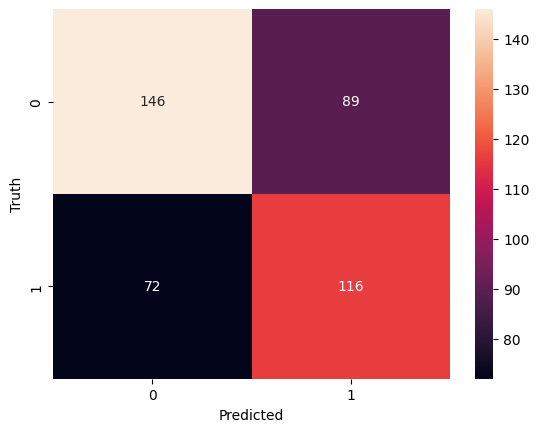

In [29]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

**Validation**

In [30]:
# # Making predictions

dft=pd.read_csv("project_test.csv")
dft

,Label1,Comments1
0,0,Our driver never showed up and Uber cancelled ...
1,1,"My driver, Rohan was nice, but when I tried to..."
2,1,Uber is overcharging for Toll fees. When In Fl...
3,0,I called uber for going home two days ago and ...
4,1,"Ordering a ride, then putting your 10, 12, and..."


In [31]:
dft_comments=dft.Comments1
dft_comments

0    Our driver never showed up and Uber cancelled ...
1    My driver, Rohan was nice, but when I tried to...
2    Uber is overcharging for Toll fees. When In Fl...
3    I called uber for going home two days ago and ...
4    Ordering a ride, then putting your 10, 12, and...
Name: Comments1, dtype: object

In [32]:
test_pred=model.predict(dft_comments)
test_pred

1/1 [==============================] - 0s 32ms/step


array([[0.49924654],
       [0.5304811 ],
       [0.61804193],
       [0.71459854],
       [0.5564488 ]], dtype=float32)

In [33]:
test_pred2=test_pred.flatten()
test_pred2

array([0.49924654, 0.5304811 , 0.61804193, 0.71459854, 0.5564488 ],
      dtype=float32)

In [36]:
test_final=np.where(test_pred2 > 0.5, 1, 0)
test_final

array([0, 1, 1, 1, 1])

In [37]:
test_label=dft.Label1
test_label

0    0
1    1
2    1
3    0
4    1
Name: Label1, dtype: int64

In [38]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(test_label, test_final) 
accuracy

0.8

In [39]:
for i in range(0,5):
  print(dft_comments[i])
  if (test_final[i] ==0):
    print("Review - Fair(related to driver)")
  else:
    print("Review - unfair(not related)")  
  print("\n")

Our driver never showed up and Uber cancelled our ride, not us. They charged us a cancellation fee for them cancelling. When I disputed it they would only credit it on future ride instead of refund back to our credit card. Why am I only getting a credit on account instead of a full refund to my credit card used?? This is not right what you have done when it was a Uber error.
Review - Fair(related to driver)


My driver, Rohan was nice, but when I tried to add tip I noticed that he had switched my $9 9am fare in French Quarter to someone else's 2pm trip in Metairie for $28.00! UBER refused to acknowledge. 5 attempts to rectify problem and received nothing but irrelevant automated replies. If you get in the car with Rohan in NOLA and he says he can't get his system to work, it's a a SCAM. Terrible customer service from UBER with zero relevant assistance after 7 days of requesting corrected bill. BEWARE.
Review - unfair(not related)


Uber is overcharging for Toll fees. When In Florida th